C:\Users\facci\OneDrive\Documents\Programming fun\PVC Tensile Experiment\src\pvc_tensile_experiment\Functions.py:199: SyntaxWarning: invalid escape sequence '\{'
  df.to_csv(f"Processed data\{testName}.csv", sep = ',', header = True, index = False)


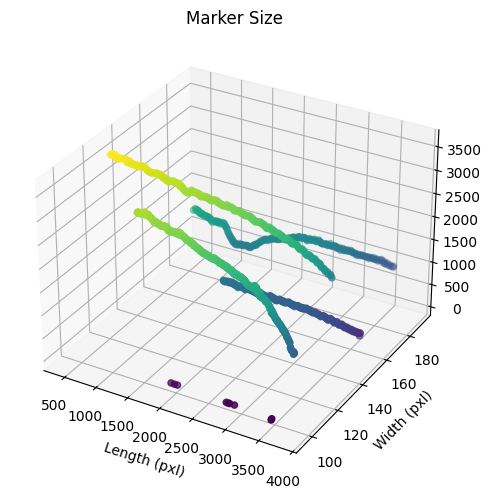

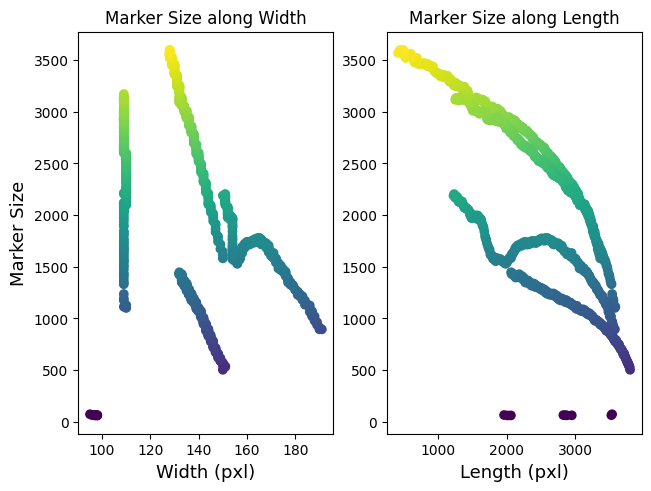

In [1]:
'''Test if marker recognization is sufficient'''
from pvc_tensile_experiment.Functions import *

# variable inputs
folderName = 'Data/PVC P8 Test_0'

# set pixel area limits for the search region and the
# the lower color bound
searchRegion = [60, 4500]
lowerColorLims = [80, 150, 130] # min [80, 80, 100], max [80, 150, 125]

# define the opening kernel and use
kernelSize = 3
useKernel = False

# check the particle areas are increasing and verify if there are abnormal changes to position
MaskCheck(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)


In [2]:
'''Run the particle tracking, compute strain, and couple stress and strain'''
from pvc_tensile_experiment.Functions import *

# find the tracked particles
tracked = ParticleIdentify(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)

# process the data and compile, getting strain and stress calculations 
axDist, axStrain, transDist, transStrain, stress  = StrainFunction(folderName, tracked)


Frame 12225: 4 trajectories present.


In [ ]:
"""Overlay the individual processed data set on a plot"""
from pvc_tensile_experiment.Functions import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P4'

# list the processed file names
fileNames = [i for i in os.listdir('Processed data/Modeling Data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")

for name in fileNames:
    # read the processed data files 
    axDist, axStrain, transDist, transStrain, stress = DataReader(name)
    
    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio

    # remove csv from the name
    name = name.removesuffix('.csv').removeprefix('PVC ')

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrain, label = f'{name}')
    axs[1].plot(transStrain, label = f'{name}')
    axs[0].set_title('Axial Strain')
    axs[1].set_title('Transverse Strain')
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Frame')
    axs[0].set_ylabel('Strain (pxl/pxl)')
    axs[1].set_ylabel('Strain (pxl/pxl)')
    axs[0].legend(fontsize = 7)
    axs[1].legend(fontsize = 7)

    # plot poissons ratio 
    axs1.plot(axStrain, transStrain, label = f'{name}')
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain (pxl/pxl)')
    axs1.set_ylabel('Transverse Strain (pxl/pxl)')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].plot(axStrain, stress, label = f'{name}')   
    axs2[1].plot(axStrainTrue, stressTrue, label = f'{name}')
    axs2[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs2[0].set_ylabel('Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Strain')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

plt.show()


In [ ]:
"""Overlay the all used datasets on a plot"""
from pvc_tensile_experiment.Functions import DataComplile
import matplotlib.pyplot as plt; import numpy as np

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio
    
    # define marker size
    size = 1

    # plot poissons ratio 
    axs1.scatter(axStrain, transStrain, label = f'{plastiRatio}', s = size)
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain (pxl/pxl)')
    axs1.set_ylabel('Transverse Strain (pxl/pxl)')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].plot(axStrain, stress, label = f'{plastiRatio}')   
    axs2[1].scatter(axStrainTrue, stressTrue, label = f'{plastiRatio}', s = size)
    axs2[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs2[0].set_ylabel('Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Strain')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

    
plt.show()

In [ ]:
"""Combined elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# define the plasticizer ration we want
plastiRatio = 'P8'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = DataComplile(plastiRatio)

# define the elastic region
elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.25 and i > 0.05]
elasAxStrain = axStrain[elasRegion]
elasTransStrain = transStrain[elasRegion]
elasStress = stress[elasRegion]

# curve fit the elastic region. find the 
xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)


# plot engineering stress vs strain
plt.figure(0)
plt.scatter(elasAxStrain, elasStress)
plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Stress (MPa)')
plt.title('Elastic Modulus')
plt.show()

# plot poissons ratio
plt.figure(1)
plt.scatter(elasAxStrain, elasTransStrain)
plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Transverse Strain (pxl/pxl)')
plt.title('Poissons Ratio')
plt.show()

In [ ]:
"""Curve fitting"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Conversion functions
def engineering_to_true_strain(eps_eng):
    return np.log(1 + eps_eng)

def engineering_to_true_stress(sigma_eng, eps_eng):
    return sigma_eng * (1 + eps_eng)

# Hyperelastic models
def neo_hookean(eps_eng, C1):
    lambda_ = 1 + eps_eng
    return C1 * (lambda_ - 1 / lambda_**2)

def mooney_rivlin(eps_eng, C1, C2):
    lambda_ = 1 + eps_eng
    return 2 * (C1 + C2 / lambda_) * (lambda_ - 1 / lambda_**2)

def arruda_boyce(eps_eng, mu, lambda_m):
    lambda_ = 1 + eps_eng
    I1 = lambda_**2 + 2 / lambda_
    return mu * (lambda_ - 1 / lambda_**2) * (1 + (I1 - 3) / (10 * lambda_m**2))

def ogden(eps_eng, mu, alpha):
    lambda_ = 1 + eps_eng
    return (2 * mu / alpha) * (lambda_**alpha - lambda_**(-alpha / 2))

def gent(eps_eng, mu, Jm):
    lambda_ = 1 + eps_eng
    I1 = lambda_**2 + 2 / lambda_
    return mu * (lambda_ - 1 / lambda_**2) / (1 - (I1 - 3) / Jm)

def yeoh(eps_eng, C1, C2, C3):
    lambda_ = 1 + eps_eng
    I1_bar = lambda_**2 + 2 / lambda_
    return 2 * (C1 + 2 * C2 * (I1_bar - 3) + 3 * C3 * (I1_bar - 3)**2) * (lambda_ - 1 / lambda_**2)

# R-squared calculation
def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Example synthetic data (replace with your experimental data)
eps_eng = axStrain  # Engineering strain
sigma_eng = stress  # Simulated stress data

# Fit models
models = {
    "Neo-Hookean": (neo_hookean, [1]),
    "Mooney-Rivlin": (mooney_rivlin, [1, 1]),
    "Arruda-Boyce": (arruda_boyce, [1, 5]),
    "Ogden": (ogden, [1, 2]),
    "Gent": (gent, [1, 10]),
    "Yeoh": (yeoh, [1, 0.1, 0.01])
}

plt.figure(figsize = (10, 8))
plt.scatter(eps_eng, sigma_eng, color='black', label='Experimental Data')

for name, (model, p0) in models.items():
    popt, _ = curve_fit(model, eps_eng, sigma_eng, p0=p0)
    sigma_fit = model(eps_eng, *popt)
    r_squared = calculate_r_squared(sigma_eng, sigma_fit)
    plt.plot(eps_eng, sigma_fit, label=f'{name} Fit (R² = {r_squared:.3f})')

plt.xlabel('Engineering Strain')
plt.ylabel('Engineering Stress')
plt.title('Hyperelastic Model Fits to Uniaxial Data')
plt.legend()
plt.grid()
plt.show()
